In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import numpy as np
import torch

from emle.models import EMLE
from emle.train._utils import pad_to_max
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, kendalltau

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
# Set the path to the models
models_dict = {
    "QM7-Species": "../../emle_models/emle_qm7_aev.mat",
    "Bespoke-Iter2-Species": "../../emle_models/ligand_bespoke_iter2.mat",
    "Patched-Iter2-Species": "../../emle_models/ligand_patched_species_iter2.mat"
}

In [3]:
# Load the testing data 
testing_data = [
    "../../data/testing_training_data/merged_testing_data_iter_1.pkl",
    "../../data/testing_training_data/merged_testing_data_iter_2.pkl",
    "../../data/testing_training_data/merged_testing_data_iter_3.pkl",
]

xyz_qm = []
xyz_mm = []
z = []
charges_mm = []
e_static_ref = []
e_ind_ref = []

for data in testing_data:
    testing_data = pkl.load(open(data, "rb"))
    xyz_qm += testing_data["xyz_qm"]
    xyz_mm += testing_data["xyz_mm"]
    z += testing_data["z"]
    charges_mm += testing_data["charges_mm"]
    e_static_ref += testing_data["e_static"]
    e_ind_ref += testing_data["e_ind"]

# Pad to max and convert to torch tensors
xyz_qm = pad_to_max(xyz_qm)
xyz_mm = pad_to_max(xyz_mm)
z = pad_to_max(z)
charges_mm = pad_to_max(charges_mm)
e_static_ref = torch.tensor(e_static_ref)
e_ind_ref = torch.tensor(e_ind_ref)

In [4]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}

HARTEE_TO_KJ_MOL = 2625.5
for model_name, model_path in models_dict.items():
    emle_model = EMLE(model=model_path, alpha_mode="species").double()

    e_static_emle, e_ind_emle = emle_model.forward(
        z,
        charges_mm,
        xyz_qm,
        xyz_mm,
    )

    e_static_emle = e_static_emle.detach().cpu().numpy()
    e_ind_emle = e_ind_emle.detach().cpu().numpy()

    emle_energy_dict[model_name] = {
        "e_static_emle": e_static_emle * HARTEE_TO_KJ_MOL,
        "e_ind_emle": e_ind_emle * HARTEE_TO_KJ_MOL,
    }


with open("emle_energy_dict.pkl", "wb") as f:
    pkl.dump(emle_energy_dict, f)

In [5]:
def compute_metrics(true_values, predicted_values):
    """Compute the mean unsigned error (MUE), mean signed error (MSE), spearmans rho, Kendall's tau, and R2 score."""
    
    rmse = np.sqrt(np.mean((predicted_values - true_values) ** 2))
    mue = np.mean(np.abs(predicted_values - true_values))
    mse = np.mean(predicted_values - true_values)
    kendall = kendalltau(true_values, predicted_values)[0]
    pearson = pearsonr(true_values, predicted_values)[0]
    r2 = r2_score(true_values, predicted_values)

    return mue, mse, kendall, pearson, r2, rmse

/tmp/ipykernel_1080344/1735376414.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(reference, predicted, cmap='Blues', label="Static", alpha=0.5)
/tmp/ipykernel_1080344/1735376414.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(reference, predicted, cmap='Blues', label="Static", alpha=0.5)
/tmp/ipykernel_1080344/1735376414.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(reference, predicted, cmap='Blues', label="Static", alpha=0.5)


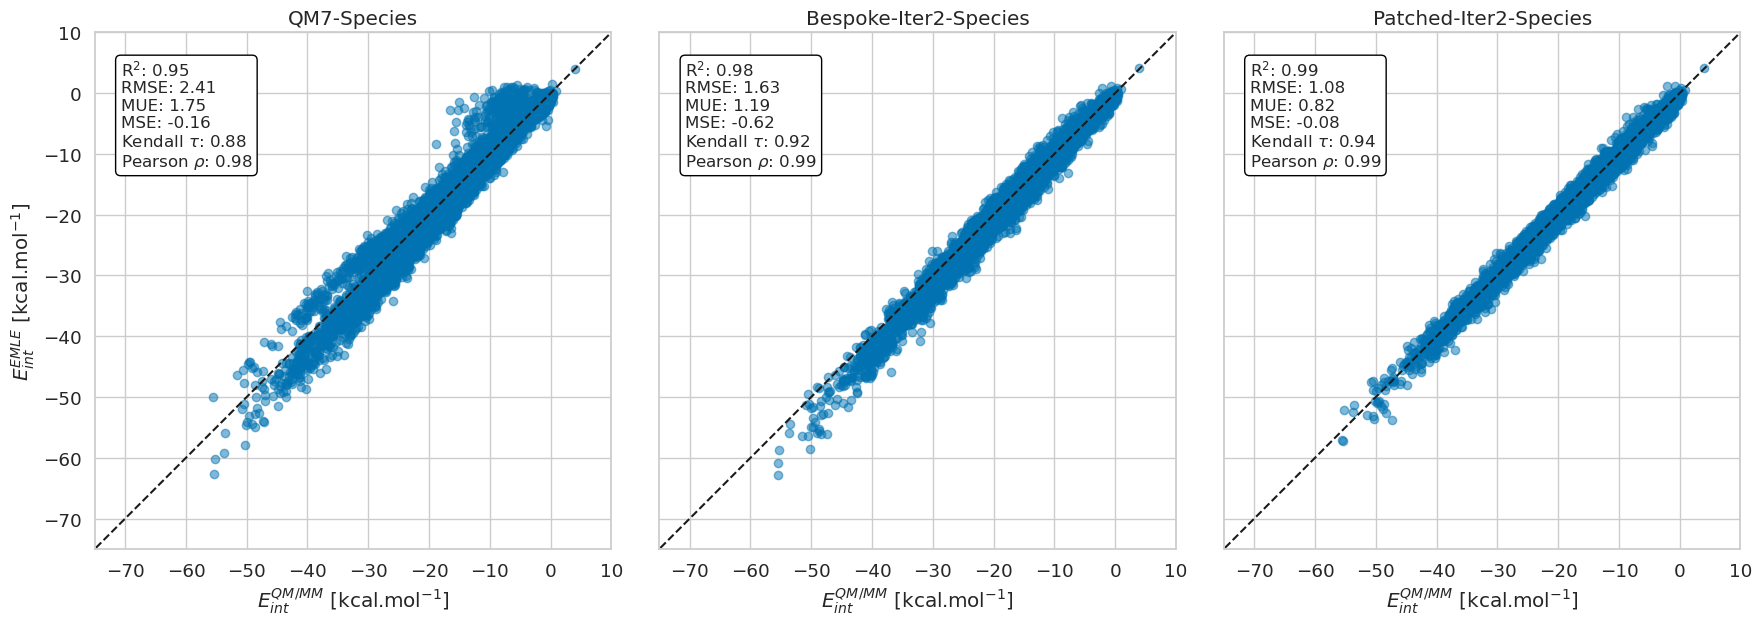

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2, palette="colorblind")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True) 

x = np.linspace(-1000, 1000, 100)
y = x

xlims = (-75, 10)
ylims = (-75, 10)

for i, (model_name, emle_energy) in enumerate(emle_energy_dict.items()):
    axes[i].set_aspect("equal")
    axes[i].set_xlim(*xlims)
    axes[i].set_ylim(*ylims)
    axes[i].plot(x, y, "k--", label="Reference Line")

    predicted = emle_energy["e_static_emle"]+ emle_energy["e_ind_emle"]
    reference = e_static_ref.numpy() + e_ind_ref.numpy()

    predicted = predicted / 4.184
    reference = reference / 4.184

    mue, mse, kendall, pearson, r2, rmse = compute_metrics(reference, predicted)
    
    scatter = axes[i].scatter(reference, predicted, cmap='Blues', label="Static", alpha=0.5)

    axes[i].set_xlabel("$E^{QM/MM}_{int}$ [kcal.mol$^{-1}]$")
    #axes[i].set_ylabel("$E^{EMLE}$ [kcal.mol$^{-1}]$")
    axes[i].set_title(f"{model_name}")

    # Display RMSE, MSE, R^2 on the Static plot
    axes[i].text(
        0.05,
        0.95,
        f"R$^2$: {r2:.2f}\nRMSE: {rmse:.2f} \nMUE: {mue:.2f}\nMSE: {mse:.2f}\nKendall $\\tau$: {kendall:.2f}\nPearson $\\rho$: {pearson:.2f}",
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

axes[0].set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}]$")

plt.tight_layout()
plt.savefig("fig3_emle_model_perf.pdf", dpi=300, bbox_inches="tight")

plt.show()